# Import

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 55 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619436 sha256=aa7422036a88a8bc65cde47f281d4d2418163b90a1476cc61fa16cf0ca281041
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import gzip
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.preprocessing import LabelEncoder
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import re
import random
import zipfile,os

# Data loading

download [Book Recommendation Dataset](https://www.kaggle.com/arashnic/book-recommendation-dataset) dengan kaggle API

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arashnic/book-recommendation-dataset

 38% 9.00M/23.8M [00:00<00:00, 89.9MB/s]
100% 23.8M/23.8M [00:00<00:00, 117MB/s] 


In [ ]:
local_zip = 'book-recommendation-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

# EDA

## Books
menganalisis karakteristik data buku

In [ ]:
books_df = pd.read_csv('Books.csv')
books_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


terdapat beberapa null value pada data buku (author, publisher, Image-URL-L), dan beberapa judul duplikat karena jumlah judul dan ISBN tidak sama, maka perlu dilakukan proses handling missing value dan drop duplicate pada data preparation

In [ ]:
print('Jumlah ISBN:', len(books_df.ISBN.unique()))
print('Jumlah judul:', len(books_df['Book-Title'].unique()))
print('Jumlah author:', len(books_df['Book-Author'].unique()))
print('Jumlah publisher:', len(books_df['Publisher'].unique()))

Jumlah ISBN: 271360
Jumlah judul: 242135
Jumlah author: 102024
Jumlah publisher: 16808


## Rating

menganalisis karakteristik data rating

---



In [ ]:
ratings_df = pd.read_csv('Ratings.csv')
ratings_df

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
ratings_df['Book-Rating'].describe()

count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: Book-Rating, dtype: float64

In [ ]:
print('Jumlah user:', len(ratings_df['User-ID'].unique()))
print('Jumlah buku:', len(ratings_df['ISBN'].unique()))
print('Jumlah rating diterima:', len(ratings_df))

Jumlah user: 105283
Jumlah buku: 340556
Jumlah rating diterima: 1149780


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


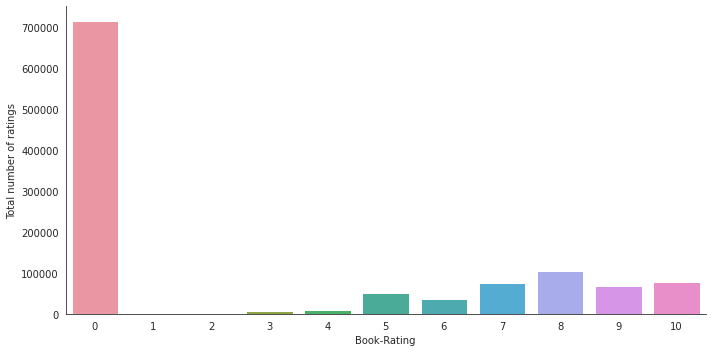

In [ ]:
with sns.axes_style('white'):
    g = sns.catplot("Book-Rating", data=ratings_df, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

dari plot jumlah rating, banyak buku yang memiliki rating 0, untuk mengurangi bias, data tersebut dapat dihapus

## Users

analisis karakteristik data user

In [ ]:
users_df = pd.read_csv('Users.csv')
users_df

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


terdapat banyak missing value pada kolom Age, maka perlu dilakukan handling missing value pada kolom age di proses data preparation

In [ ]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


# Data preparation

## Books

menyeleksi fitur yang diperlukan

In [ ]:
books = books_df[['ISBN', 'Book-Title','Book-Author', 'Publisher']]
books.head()

,ISBN,Book-Title,Book-Author,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,W. W. Norton &amp; Company


In [ ]:
# check missing value in books
books.isnull().sum()

ISBN           0
Book-Title     0
Book-Author    1
Publisher      2
dtype: int64

mengisi data kosong pada publisher dan author

In [ ]:
# fill missing value in Book Author and Publisher
books.loc[:,'Book-Author'] = books['Book-Author'].fillna('Unknown')
books.loc[:,'Publisher'] = books['Publisher'].fillna('Unknown')
books.isnull().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


ISBN           0
Book-Title     0
Book-Author    0
Publisher      0
dtype: int64

## Ratings

In [ ]:
ratings = ratings_df
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [ ]:
print('Jumlah rating 0 :', ratings['Book-Rating'].eq(0).sum())
ratings.shape

Jumlah rating 0 : 716109


(1149780, 3)

menghapus data rating 0

In [ ]:
ratings = ratings[ratings['Book-Rating']>0]
ratings.shape

(433671, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


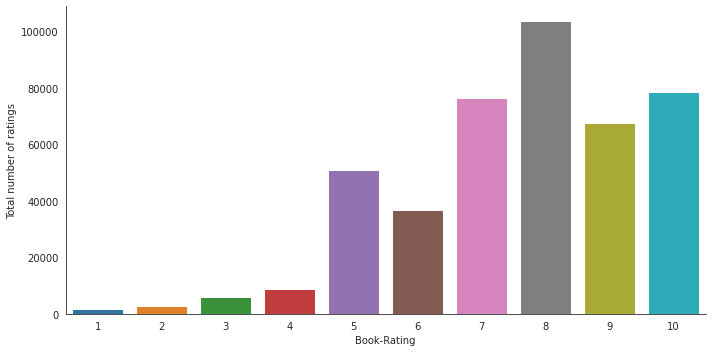

In [ ]:
with sns.axes_style('white'):
    g = sns.catplot("Book-Rating", data=ratings, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

## Users

In [ ]:
users = users_df
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

terdapat banyak sekali missing value pada kolom Age, dan tidak mungkin kita menghapus user yang tidak memiliki umur, sehingga missing value dapat diisi dengan modus dari Age, yaitu 24 tahun

In [ ]:
users['Age'] = users['Age'].fillna(users['Age'].mode())
users.isnull().sum()

User-ID          0
Location         0
Age         110761
dtype: int64

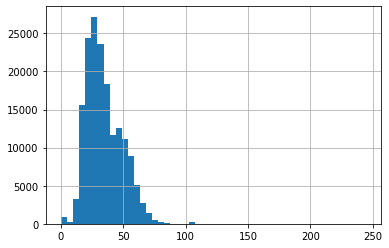

In [ ]:
users['Age'].hist(bins=50)

menggabungkan data buku dan rating

In [ ]:
book_rating = pd.merge(ratings, books, on=['ISBN'],)
book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
0,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,Doubleday
4,11676,038550120X,10,A Painted House,JOHN GRISHAM,Doubleday


# Popularity based recommendation

merekomendasikan buku paling populer berdasarkan rata rata rating dan jumlah rating yang diterima

## By rating average

In [ ]:
book_average_rating = book_rating.groupby('ISBN')['Book-Rating'].mean().sort_values(ascending=False)
book_average_rating

ISBN
0738204676    10.0
0863184022    10.0
0486254372    10.0
0486254437    10.0
0486256111    10.0
              ... 
0312955081     1.0
0307617963     1.0
080105060X     1.0
0442292767     1.0
0553196529     1.0
Name: Book-Rating, Length: 149836, dtype: float64

berdasarkan plot, terdapat lebih dari 20000 buku yang memiliki rating tertinggi, maka tidak bisa merekomendasikan 20 buku terbaik hanya berdasarkan rata-rata rating saja

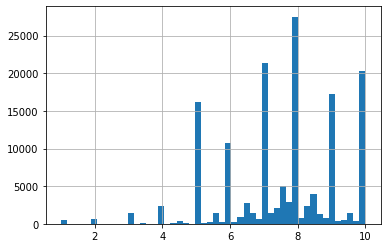

In [ ]:
book_average_rating.hist(bins=50)

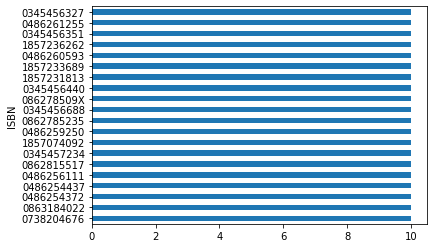

In [ ]:
book_average_rating.head(20).plot(kind='barh')

## By amount rating received

diperlukan informasi lain untuk merekomendasikan buku terbaik, dapat menggunakan jumlah rating yang diterima tiap buku

In [ ]:
# recommend product by rating received
book_popularity_count = book_rating.groupby('ISBN')['Book-Rating'].count().sort_values(ascending=False)
book_popularity_count

ISBN
0316666343    707
0971880107    581
0385504209    487
0312195516    383
0060928336    320
             ... 
0789710684      1
078971079X      1
0789711621      1
0789712229      1
0000913154      1
Name: Book-Rating, Length: 149836, dtype: int64

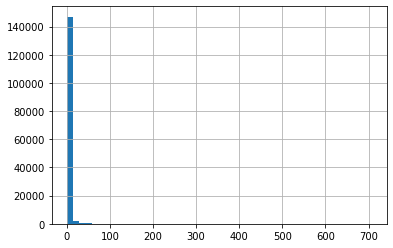

In [ ]:
book_popularity_count.hist(bins=50)

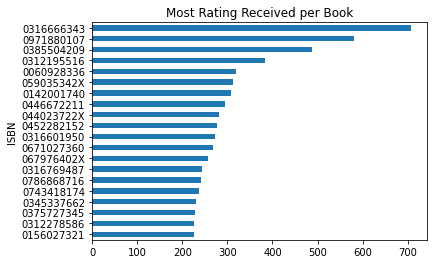

In [ ]:
book_popularity_count.head(20).sort_values().plot(kind='barh',
                                                  title='Most Rating Received per Book')

## Weighted rating

untuk menggabungkan kedua informasi, dibuatlah weighted rating berdasarkan rata-rata rating dan jumlah rating diterima, kemudian memilih 20 produk terbaik berdasarkan weighted rating

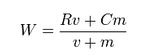

dimana

v = jumlah rating diterima

R = rata-rata rating per produk

C = rata-rata rating seluruh produk

m = minimal jumlah rating yang diterima

In [ ]:
popular_recommendation = pd.concat([book_average_rating, book_popularity_count],
                                   axis=1, join='inner',
                                   keys=['Average Rating', 'Rating Received'])

In [ ]:
v = popular_recommendation['Rating Received'] # jumlah rating diterima
R = popular_recommendation['Average Rating'] # rata-rata rating per produk
C = popular_recommendation['Average Rating'].mean() # rata-rata rating seluruh produk
m = popular_recommendation['Rating Received'].quantile(0.75) # minimal jumlah rating yang diterima

popular_recommendation['Weighted Rating'] = ((R*v)+(C*m))/(v+m)
popular_recommendation = popular_recommendation.sort_values('Weighted Rating', ascending=False)
popular_recommendation.head(20)

,Average Rating,Rating Received,Weighted Rating
ISBN,,,
0439425220,9.869565,23,9.682203
1888054557,10.000000,11,9.619622
0836213319,9.923077,13,9.603672
0618002235,9.720000,25,9.557596
0060256656,9.750000,20,9.547958
0394800893,10.000000,8,9.505509
0394800389,9.785714,14,9.503443
089471838X,10.000000,7,9.450565
1571456988,10.000000,7,9.450565


hasil rekomendasi dengan weighted rating

In [ ]:
popular_title = pd.merge(popular_recommendation, books[['ISBN', 'Book-Title']],
                         on='ISBN')
popular_title = popular_title[['Weighted Rating', 'Book-Title']]
popular_title = popular_title.drop_duplicates('Book-Title').set_index('Book-Title')
popular_title.head(20)

,Weighted Rating
Book-Title,
Harry Potter and the Chamber of Secrets Postcard Book,9.682203
Postmarked Yesteryear: 30 Rare Holiday Postcards,9.619622
Dilbert: A Book of Postcards,9.603672
"The Two Towers (The Lord of the Rings, Part 2)",9.557596
The Giving Tree,9.547958
The Sneetches and Other Stories,9.505509
Fox in Socks (I Can Read It All by Myself Beginner Books),9.503443
Natural California: A Postcard Book,9.450565
Uncle John's Supremely Satisfying Bathroom Reader (Uncle John's Bathroom Reader),9.450565


plot hasil rekomendasi berdasarkan weighter rating

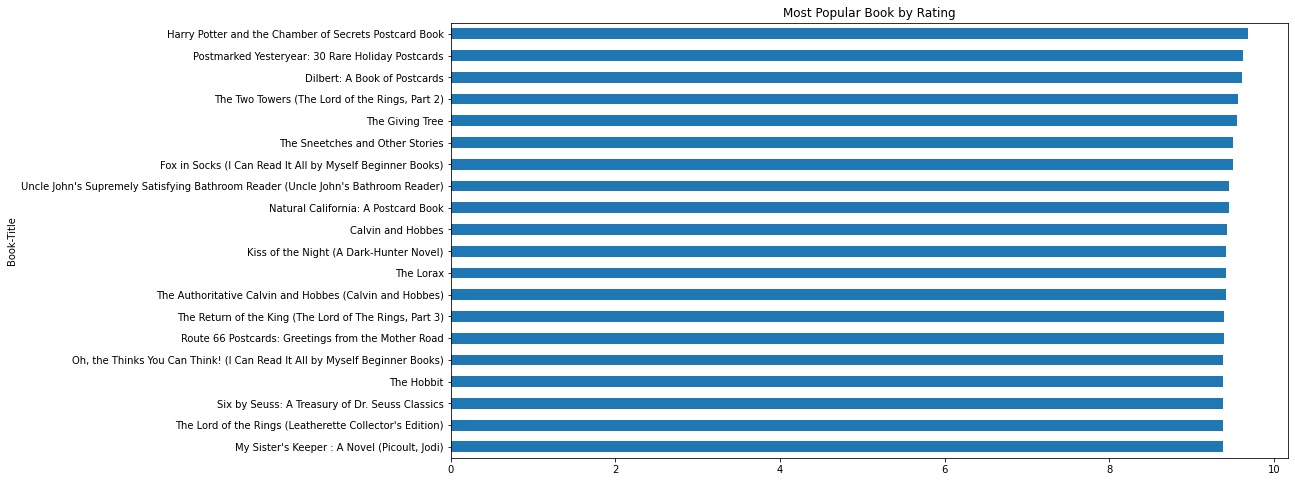

In [ ]:
popular_title['Weighted Rating'].head(20).sort_values().plot(kind='barh', figsize=(15,8),
                                                             title='Most Popular Book by Rating')

# Content-based recommendation

Merekomendasikan buku berdasarkan book author

data buku yang sangat banyak (271360 buku) perlu menggunakan resource RAM yang sangat besar pula, maka kita dapat menyeleksi 10000 buku terbaik berdasarkan rekomendasi buku terpopuler sebelumnya untuk direkomendasikan

In [ ]:
sorted_books = pd.DataFrame(popular_recommendation.index, columns=['ISBN'])
content_df = pd.merge(sorted_books, books, on='ISBN')
content_df = content_df.drop_duplicates('Book-Title').head(10000)
content_df

,ISBN,Book-Title,Book-Author,Publisher
0,0439425220,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,Scholastic
1,1888054557,Postmarked Yesteryear: 30 Rare Holiday Postcards,Pamela E. Apkarian-Russell,Collectors Press
2,0836213319,Dilbert: A Book of Postcards,Scott Adams,Andrews McMeel Pub
3,0618002235,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,Houghton Mifflin Company
4,0060256656,The Giving Tree,Shel Silverstein,HarperCollins Publishers
...,...,...,...,...
10376,0810918684,Animalia,Graeme Base,Harry N Abrams
10377,0806504439,A pictorial history of sex in films,Parker Tyler,Citadel Press
10378,0806504064,"Barbra, the first decade: The films and career...",James Spada,Citadel Press
10379,344275044X,Schneeland.,Elisabeth Rynell,Btb Bei Goldmann


## TF-IDF vectorizer

melakukan transformasi book author menjadi matrix dengan TF-IDF Vectorizer

In [ ]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(content_df['Book-Author'])
tfidf_matrix.shape

(10000, 6637)

## Cosine similarity

mencari kesamaan antar buku berdasarkan authornya dengan cosine similarity

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim 
# dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=content_df['Book-Title'],
                             columns=content_df['Book-Title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape: (10000, 10000)


Book-Title,"The History of Beads : From 30,000 B.C. to the Present (Beadwork Books)",Cyanide Wells,The Hobbit (Illustrated Edition),The Chosen,Just Say Good Dog!,Passaggio in ombra (I narratori/Feltrinelli),Durer (Master Artists Library),If You Give a Mouse a Cookie/Mini Book and Mouse Doll,The great code: The Bible and literature,My Father's Dragon (Three Tales of My Father's Dragon)
Book-Title,,,,,,,,,,
The Dream Encyclopedia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Bilbo, Le Hobbit",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A guide to birdwatching in Hungary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
And Justice There Is None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Seven Whispers: Listening to the Voice of Spirit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nations Favourite Love Poems a Selection,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Matilda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Children of Henry VIII,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Neverwhere,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Book recommendation

In [ ]:
def book_recommendations(book_title, similarity_data=cosine_sim_df, 
                         items=content_df[["Book-Title","Book-Author"]], k=10):
    """
    Rekomendasi Resto berdasarkan kemiripan dataframe
 
    Parameter:
    ---
    book_title : tipe data string (str)
                Judul Buku (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan buku sebagai 
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---
    Pada index ini, kita mengambil k dengan nilai similarity terbesar 
    pada index matrix yang diberikan (i).
    """

    # Mengambil data dengan menggunakan argpartition untuk melakukan 
    # partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:, book_title].to_numpy().argpartition(
        range(-1, -k, -1)
    )

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop book_title agar judul buku yang dicari 
    # tidak muncul dalam daftar rekomendasi
    closest = closest.drop(book_title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

merekomendasikan buku lain berdasarkan author dari buku tertentu

In [ ]:
book_title = 'Harry Potter and the Goblet of Fire'
book_recom = book_recommendations(book_title)
recom_rating = pd.merge(book_recom, popular_title, on='Book-Title')
recom_rating

,Book-Title,Book-Author,Weighted Rating
0,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,9.682203
1,Harry Potter and the Prisoner of Azkaban (Book...,J. K. Rowling,8.611017
2,Harry Potter and the Chamber of Secrets (Harry...,J. K. Rowling,8.611017
3,"Harry Potter and the Sorcerer's Stone (Book 1,...",J. K. Rowling,8.351695
4,Harry Potter and the Prisoner of Azkaban (Book...,J.K. ROWLING,8.411017
5,Harry Potter y la camara secreta,J. K. Rowling,8.351695
6,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,8.506886
7,"Harry Potter and the Sorcerer's Stone (Book 1,...",J. K. Rowling,8.351695
8,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,8.763772
9,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,9.237806


# Collaborative filtering (model based) recommendation
Merekomendasikan buku lain kepada user yang memberi rating buku

In [ ]:
user_rating = book_rating
user_rating

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
0,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,Doubleday
4,11676,038550120X,10,A Painted House,JOHN GRISHAM,Doubleday
...,...,...,...,...,...,...
383837,276688,0425156737,2,Graven Images,Jane Waterhouse,Berkley Publishing Group
383838,276688,0671563149,6,MUDDY WATER (Peter Bartholomew Mysteries),Sally Gunning,Pocket
383839,276688,1575660792,7,Gray Matter,Shirley Kennett,Kensington Publishing Corporation
383840,276704,0380796155,5,White Abacus,Damien Broderick,Eos


## Label encoding

encoder User ID dan Book Title

In [ ]:
le = LabelEncoder()
user_rating['UserID'] = le.fit_transform(user_rating['User-ID'])
user_rating['TitleID'] = le.fit_transform(user_rating['Book-Title'])
user_rating.drop('User-ID', axis=1, inplace=True)
user_rating

,ISBN,Book-Rating,Book-Title,Book-Author,Publisher,UserID,TitleID
0,0155061224,5,Rites of Passage,Judith Rae,Heinle,67541,84140
1,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press,67542,46362
2,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,Cambridge University Press,67542,97833
3,038550120X,7,A Painted House,JOHN GRISHAM,Doubleday,67543,3064
4,038550120X,10,A Painted House,JOHN GRISHAM,Doubleday,2719,3064
...,...,...,...,...,...,...,...
383837,0425156737,2,Graven Images,Jane Waterhouse,Berkley Publishing Group,67537,43523
383838,0671563149,6,MUDDY WATER (Peter Bartholomew Mysteries),Sally Gunning,Pocket,67537,63876
383839,1575660792,7,Gray Matter,Shirley Kennett,Kensington Publishing Corporation,67537,43547
383840,0380796155,5,White Abacus,Damien Broderick,Eos,67538,131513


## Model development

Mentraining data user buku dengan model SVD dari library surprise dan mengevaluasi dengan 5-fold cross validation menggunakan matriks RMSE dan MAE. evaluasi model dengan test set pada 5 fold menghasilkan rata-rata RMSE 1.64, rata-rata MAE 1.27

In [ ]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(user_rating[['UserID', 'TitleID', 'Book-Rating']],
                            reader)
svd = SVD(verbose=False, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6431  1.6506  1.6365  1.6401  1.6484  1.6437  0.0052  
MAE (testset)     1.2732  1.2777  1.2669  1.2695  1.2735  1.2722  0.0037  
Fit time          12.37   12.72   12.80   12.83   12.90   12.72   0.19    
Test time         0.75    0.74    0.85    0.82    0.87    0.80    0.05    


{'fit_time': (12.366872310638428,
  12.720317363739014,
  12.801883935928345,
  12.830581188201904,
  12.900733947753906),
 'test_mae': array([1.27321448, 1.27767866, 1.26693489, 1.26946772, 1.27353167]),
 'test_rmse': array([1.64311406, 1.65056353, 1.63650939, 1.64007566, 1.64843846]),
 'test_time': (0.7500429153442383,
  0.7379298210144043,
  0.8500516414642334,
  0.81644606590271,
  0.8664963245391846)}

## Merekomendasikan buku berdasarkan riwayat rating user

prediksi rating buku dengan model SVD, kemudian mengurutkan 10 buku dengan prediksi rating tertinggi

In [ ]:
def user_recommendation(userid):
    user = user_rating[['ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'TitleID']]
    user = user.reset_index()
    # getting full dataset
    data = Dataset.load_from_df(user_rating[['UserID','TitleID','Book-Rating']], reader)
    trainset = data.build_full_trainset()
    svd.fit(trainset)
    user['Estimate_Score'] = user['TitleID'].apply(lambda x: svd.predict(userid, x).est)
    user = user.drop(['index','TitleID'], axis = 1)
    user = user.sort_values('Estimate_Score' , ascending = False)
    counts1 = user['Estimate_Score'].value_counts()
    user = user[user['Estimate_Score'].isin(counts1[counts1 == 1].index)]
    return user.head(10)

merekomendasikan buku lain kepada user yang memberi rating pada buku Harry Potter

In [ ]:
# mencari user yang menyukai buku Harry Potter sebagai contoh
user_rating[user_rating['Book-Title'].str.contains('Harry Potter')]

,ISBN,Book-Rating,Book-Title,Book-Author,Publisher,UserID,TitleID
367,043935806X,7,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,Scholastic,67553,45385
368,043935806X,10,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,Scholastic,67966,45385
369,043935806X,9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,Scholastic,481,45385
370,043935806X,9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,Scholastic,1461,45385
371,043935806X,10,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,Scholastic,1511,45385
...,...,...,...,...,...,...,...
356778,043932162X,8,Harry Potter Schoolbooks Box Set: Two Classic ...,J. K. Rowling,Scholastic,53159,45364
356779,043932162X,10,Harry Potter Schoolbooks Box Set: Two Classic ...,J. K. Rowling,Scholastic,65422,45364
373343,0972322108,10,The Hidden Key to Harry Potter: Understanding ...,John Granger,Zossima Press,60037,107251
373626,043935806x,10,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,Scholastic,60216,45385


In [ ]:
user_id = 60216

In [ ]:
print('User telah merating buku :')
user_rating[user_rating['UserID'].eq(user_id)]

User telah merating buku :


,ISBN,Book-Rating,Book-Title,Book-Author,Publisher,UserID,TitleID
301,0451166892,10,The Pillars of the Earth,Ken Follett,Signet Book,60216,113719
837,0060096195,8,The Boy Next Door,Meggin Cabot,Avon Trade,60216,100031
2132,0385504209,8,The Da Vinci Code,Dan Brown,Doubleday,60216,102703
6141,0440414806,9,Holes (Yearling Newbery),LOUIS SACHAR,Yearling,60216,47544
10901,0452284449,7,The Virgin Blue,Tracy Chevalier,Plume Books,60216,119648
12381,0316666343,8,The Lovely Bones: A Novel,Alice Sebold,"Little, Brown",60216,110229
32754,0385730586,9,Sisterhood of the Traveling Pants,ANN BRASHARES,Delacorte Books for Young Readers,60216,90140
50748,0312243022,5,The Hours : A Novel,Michael Cunningham,Picador,60216,107594
50792,0312983824,7,Faking It,Jennifer Crusie,St. Martin's Paperbacks,60216,36399
53504,0142001430,7,Year of Wonders,Geraldine Brooks,Penguin Books,60216,134419


In [ ]:
print('Rekomendasi buku yang mungkin disukai user')
user_recommendation(user_id)

Rekomendasi buku yang mungkin disukai user


,ISBN,Book-Title,Book-Author,Publisher,Estimate_Score
325635,0813524660,Star Trek and History: Race-Ing Toward a White...,Daniel Bernardi,Rutgers University Press,8.011331
335979,1575025590,Kindred spirits: Family legends &amp; childhoo...,Nicole McGill,China Grove,8.000753
356613,0198711913,The Complete Works (Oxford Shakespeare S.),William Shakespeare,Oxford University Press,7.997956
375198,0393037525,Source Readings in Music History,W. Oliver Strunk,W. W. Norton &amp; Company,7.990188
343308,0752837591,Stone Mistress (Daughters of a Granite Land),Anita Burgh,Trafalgar Square,7.986423
350207,0140074570,The Pool in the Desert (Penguin Short Fiction),Sara Jeannette Duncan,Penguin USA,7.985326
278246,0395701465,The Upstairs Cat,Karla Kuskin,Clarion Books,7.982745
279466,1552977099,Warblers of the Great Lakes Region and Eastern...,Chris G. Earley,Firefly Books Ltd,7.977037
307956,0373510365,Less Of A Stranger #36 (Nora Roberts Language ...,Nora Roberts,Silhouette,7.976617
275078,1892112124,"No Greater Joy, Volume 3",Michael Pearl,"No Greater Joy Ministries, Inc.",7.974886
